PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 0%, Final Accuracy: 96.83%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 10%, Final Accuracy: 38.76%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 20%, Final Accuracy: 9.81%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 30%, Final Accuracy: 9.75%
PreAgg: NNM, Aggregator: trimmed_mean, Byzantine ratio: 40%, Final Accuracy: 10.76%


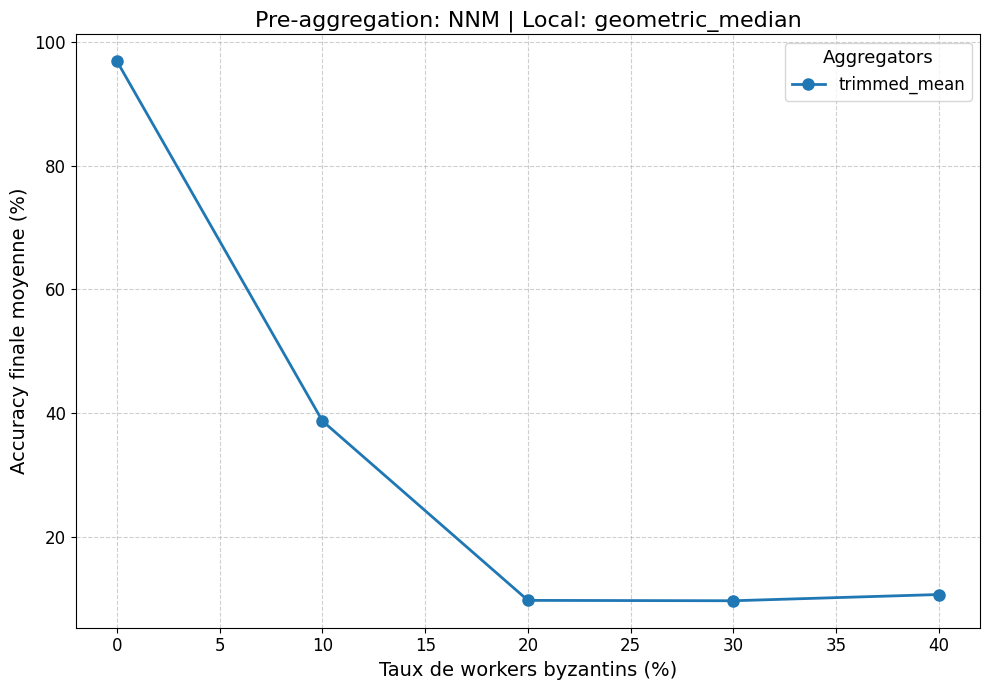

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl
import torch.nn.functional as F

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_gaussian_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.1, min_processing_time=3):
    peak_means = [0.25, 0.5, 0.75]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 2, 3])
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 2 * intensity
            duration = random.randint(min_processing_time, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

def generate_gaussian_byzantine_availability(total_time_steps, worker_id, num_workers, std_dev_ratio=0.08, min_processing_time=2):
    off_peak_means = [0.1, 0.375, 0.9]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        intensity = random.choice([1, 1, 2])
        for _ in range(intensity):
            start_time = int(np.random.normal(loc=mean, scale=std_dev))
            start_time = max(0, min(start_time, total_time_steps - min_processing_time))
            max_extra = 1 * intensity
            duration = random.randint(1, min(min_processing_time + max_extra, total_time_steps - start_time))
            end_time = start_time + duration
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# Définition des modèles de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Workers classiques et byzantins
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None  # (complete_batch_id, mini_batch_id)
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info is None or self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

class ByzantineWorker(Worker):
    def compute_gradient(self, data, targets):
        corrupted_gradients = {}
        for name, param in self.model.named_parameters():
            corrupted_gradients[name] = torch.full_like(param, 1e6)
        return corrupted_gradients, self.current_batch_info

# ------------------------------------------------------------------------------
# Serveur qui gère le découpage en mini-batches, l'agrégation locale robuste (par mini-batch)
# puis l'agrégation globale
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None, redundancy=1,
                 local_aggregator="geometric_median"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_complete_batch = None
        self.current_batch_id = 0
        self.current_mini_batches = {}
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg  # Méthode de pré-agrégation globale (string ou None)
        self.redundancy = redundancy  # Nombre de gradients attendus par mini-batch
        self.local_aggregator = local_aggregator  # Méthode d'agrégation locale ("geometric_median", etc.)

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_complete_batch = (data, targets)
        self.current_batch_id += 1
        num_samples = data.size(0)
        mini_batches = []
        for i in range(0, num_samples, self.mini_batch_size):
            mini_data = data[i: i + self.mini_batch_size]
            mini_targets = targets[i: i + self.mini_batch_size]
            mini_batches.append((mini_data, mini_targets))
        self.current_mini_batches = {i: mini_batches[i] for i in range(len(mini_batches))}
        self.received_gradients = {i: [] for i in self.current_mini_batches.keys()}
        if self.verbose:
            print(f"[Temps {current_time}] Batch complet {self.current_batch_id} divisé en {len(mini_batches)} mini-batches.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time):
        batch_id, mini_idx = batch_info
        if batch_id != self.current_batch_id:
            return
        if mini_idx not in self.received_gradients:
            self.received_gradients[mini_idx] = []
        self.received_gradients[mini_idx].append(gradients)
        if self.verbose:
            print(f"[Temps {current_time}] Gradient reçu pour mini-batch {mini_idx} (batch {batch_id}) par worker {worker_id}. ({len(self.received_gradients[mini_idx])}/{self.redundancy})")

    def aggregate_and_update(self):
        for mini_idx, grads_list in self.received_gradients.items():
            if len(grads_list) < self.redundancy:
                if self.verbose:
                    print(f"Mini-batch {mini_idx} n'a reçu que {len(grads_list)} gradients. Attente de la redondance complète ({self.redundancy}).")
                return False

        # --- Agrégation locale robuste par mini-batch ---
        local_aggregated_gradients = {}
        for mini_idx, grads_list in self.received_gradients.items():
            local_aggregated_gradients[mini_idx] = {}
            for name in grads_list[0].keys():
                grads_tensor = torch.stack([g[name] for g in grads_list])
                grads_tensor_flat = grads_tensor.view(grads_tensor.size(0), -1)
                if self.local_aggregator == "geometric_median":
                    aggregator_local = byzfl.GeometricMedian()
                    robust_grad_flat = aggregator_local(grads_tensor_flat)
                else:
                    robust_grad_flat = grads_tensor_flat.mean(dim=0)
                robust_grad = robust_grad_flat.view(grads_tensor.shape[1:])
                local_aggregated_gradients[mini_idx][name] = robust_grad

        # --- Agrégation globale sur l'ensemble des mini-batches ---
        aggregated_gradients = {}
        for name, param in self.model.named_parameters():
            grads = [local_aggregated_gradients[idx][name] for idx in sorted(local_aggregated_gradients.keys())]
            grads_tensor = torch.stack(grads)
            original_shape = grads_tensor.shape[1:]
            grads_tensor_flat = grads_tensor.view(grads_tensor.size(0), -1)
            n = grads_tensor_flat.shape[0]
            effective_f = max(self.f, (n // 2) - 1)

            if self.preagg == "NNM":
                preaggregator = byzfl.NNM(f=self.f)
            elif self.preagg == "Bucketing":
                preaggregator = byzfl.Bucketing(s=1)
            elif self.preagg == "ARC":
                preaggregator = byzfl.ARC(f=self.f)
            else:
                preaggregator = None

            if preaggregator is not None:
                try:
                    preagg_flat = preaggregator(grads_tensor_flat)
                except Exception as e:
                    print(f"Erreur de pré-agrégation ({self.preagg}): {e}")
                    preagg_flat = grads_tensor_flat
            else:
                preagg_flat = grads_tensor_flat

            if self.aggregation_strategy == "trimmed_mean":
                aggregator = byzfl.TrMean(f=effective_f)
            elif self.aggregation_strategy == "multi_krum":
                aggregator = byzfl.MultiKrum(f=effective_f)
            elif self.aggregation_strategy == "geometric_median":
                aggregator = byzfl.GeometricMedian()
            elif self.aggregation_strategy == "average":
                aggregator = byzfl.Average()
            elif self.aggregation_strategy == "meamed":
                aggregator = byzfl.Meamed(f=effective_f)
            else:
                raise ValueError(f"Stratégie d’agrégation inconnue : {self.aggregation_strategy}")

            agg_flat = aggregator(preagg_flat)
            aggregated_gradients[name] = agg_flat.view(original_shape)

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggregated_gradients[name]
        self.optimizer.step()

        if self.verbose:
            print(f"Modèle mis à jour avec le batch complet {self.current_batch_id}.")
        return True

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré en mode événement discret
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.in_progress_workers = []

    def run(self, verbose=False):
        accuracy_history = []
        if verbose:
            print("Démarrage de la simulation...")
        self.server.get_new_complete_batch(self.global_time)
        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"\n[Temps {self.global_time}]")
            finished_workers = []
            for worker in self.in_progress_workers:
                if worker.has_finished(self.global_time):
                    mini_idx = worker.current_batch_info[1]
                    gradients, batch_info = worker.compute_gradient(*self.server.current_mini_batches[mini_idx])
                    self.server.register_gradient(gradients, batch_info, worker.worker_id,
                                                  self.global_time, worker.processing_time)
                    finished_workers.append(worker)
            for worker in finished_workers:
                self.in_progress_workers.remove(worker)
                worker.current_batch_info = None
            all_done = all(len(g_list) >= self.server.redundancy for g_list in self.server.received_gradients.values())
            if all_done:
                self.server.aggregate_and_update()
                self.server.get_new_complete_batch(self.global_time)
                self.in_progress_workers = []
            available_workers = [w for w in self.workers if w.is_available(self.global_time)
                                 and w not in self.in_progress_workers]
            for mini_idx in sorted(self.server.current_mini_batches.keys()):
                current_gradients = self.server.received_gradients.get(mini_idx, [])
                if len(current_gradients) < self.server.redundancy:
                    if available_workers:
                        worker = available_workers.pop(0)
                        data, targets = self.server.current_mini_batches[mini_idx]
                        worker.start_computation(self.global_time, (self.server.current_batch_id, mini_idx),
                                                 data, targets)
                        self.in_progress_workers.append(worker)
                        if verbose:
                            print(f"[Temps {self.global_time}] Mini-batch {mini_idx} envoyé au worker {worker.worker_id}. (Redondance {len(current_gradients)+1}/{self.server.redundancy})")
                    else:
                        break
            # Calculer l'accuracy tous les 10 pas
            if self.global_time % 10 == 0:
                current_acc = self.server.evaluate(self.test_loader)
                accuracy_history.append(current_acc)
            self.global_time += 1
        final_accuracy = self.server.evaluate(self.test_loader)
        return final_accuracy, accuracy_history

    def plot_worker_availability(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps")
        ax.set_ylabel("ID du Worker")
        ax.set_title("Disponibilité des Workers\n(bleu: honnêtes, rouge: byzantins)")
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        ax.set_yticks(range(1, max_worker_id + 1))
        plt.show()

# ------------------------------------------------------------------------------
# Fonction d'exécution d'une expérience
def run_experiment(num_runs=5, total_time_steps=288, verbose=False, byzantine_ratio=0.0,
                   aggregation_strategy='trimmed_mean', preagg=None, redundancy=1,
                   local_aggregator="geometric_median"):
    final_accuracies = []
    all_acc_histories = []
    num_worker = 200
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for run in range(num_runs):
        server = Server(train_dataset, batch_size=640, mini_batch_size=64, verbose=verbose,
                        aggregation_strategy=aggregation_strategy, preagg=preagg,
                        redundancy=redundancy, local_aggregator=local_aggregator)
        workers = []
        num_byzantine = int(num_worker * byzantine_ratio)
        byzantine_indices = set(random.sample(range(1, num_worker + 1), num_byzantine))
        for i in range(1, num_worker + 1):
            processing_time = random.randint(2, 4)
            if i in byzantine_indices:
                availability = generate_gaussian_byzantine_availability(total_time_steps, worker_id=i, num_workers=num_worker,
                                                                         min_processing_time=processing_time)
                workers.append(ByzantineWorker(server.model, server.device, i, availability, processing_time))
            else:
                availability = generate_gaussian_availability(total_time_steps, worker_id=i, num_workers=num_worker,
                                                              min_processing_time=processing_time)
                workers.append(Worker(server.model, server.device, i, availability, processing_time))
        simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
        final_acc, acc_history = simulator.run(verbose=verbose)
        final_accuracies.append(final_acc)
        all_acc_histories.append(acc_history)
    avg_final_accuracy = np.mean(final_accuracies)
    avg_acc_history = np.mean(np.array(all_acc_histories), axis=0)
    return avg_final_accuracy, avg_acc_history

# ------------------------------------------------------------------------------
# Main : Exemple d'exécution avec différents paramètres
if __name__ == "__main__":
    preagg_methods = ["NNM"]  # Vous pouvez ajouter d'autres méthodes
    aggregator_methods = ["trimmed_mean"]  # Vous pouvez ajouter d'autres méthodes
    byzantine_ratios = [0, 0.1, 0.2, 0.3, 0.4]
    num_runs = 3
    total_time_steps = 1000
    redundancy = 2  # Chaque mini-batch est traité par 2 workers
    local_aggregator = "geometric_median"  # Agrégation locale robuste avec GeometricMedian de byzfl

    for preagg in preagg_methods:
        plt.figure(figsize=(10, 7))
        final_results = []
        evolution_results = {}
        for agg in aggregator_methods:
            final_results_per_ratio = []
            evolution_results_per_ratio = {}
            for ratio in byzantine_ratios:
                avg_final_acc, avg_acc_history = run_experiment(num_runs=num_runs,
                                                                total_time_steps=total_time_steps,
                                                                verbose=False,
                                                                byzantine_ratio=ratio,
                                                                aggregation_strategy=agg,
                                                                preagg=preagg,
                                                                redundancy=redundancy,
                                                                local_aggregator=local_aggregator)
                final_results_per_ratio.append(avg_final_acc)
                evolution_results_per_ratio[ratio] = avg_acc_history
                method_name = preagg if preagg is not None else "NoPreAgg"
                print(f"PreAgg: {method_name}, Aggregator: {agg}, Byzantine ratio: {ratio*100:.0f}%, Final Accuracy: {avg_final_acc:.2f}%")
            plt.plot([r*100 for r in byzantine_ratios], final_results_per_ratio, marker='o', linewidth=2, markersize=8, label=agg)
            final_results.append(final_results_per_ratio)
            evolution_results[agg] = evolution_results_per_ratio
        title = f"Pre-aggregation: {preagg if preagg is not None else 'None'} | Local: {local_aggregator}"
        plt.xlabel("Taux de workers byzantins (%)", fontsize=14)
        plt.ylabel("Accuracy finale moyenne (%)", fontsize=14)
        plt.title(title, fontsize=16)
        plt.legend(title="Aggregators", fontsize=12, title_fontsize=13, loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        fname = f"final_accuracy_preagg_{preagg if preagg is not None else 'None'}_local_{local_aggregator}.pdf"
        plt.savefig(fname, dpi=300)
        plt.show()

        # Exemple : tracer l'évolution moyenne de l'accuracy pour un taux de byzantins donné (ici, ratio=0.2)
        # example_ratio = 0.2
        # plt.figure(figsize=(10, 7))
        # for agg in aggregator_methods:
        #     acc_history = evolution_results[agg][example_ratio]
        #     plt.plot(range(0, total_time_steps, 10), acc_history, linewidth=2, label=f"{agg}")
        # plt.xlabel("Steps (tous les 10 pas)", fontsize=14)
        # plt.ylabel("Accuracy (%)", fontsize=14)
        # plt.title(f"Évolution de l'accuracy pour Byzantine ratio = {example_ratio*100:.0f}%", fontsize=16)
        # plt.legend(title="Aggregators", fontsize=12, title_fontsize=13, loc="best")
        # plt.grid(True, linestyle='--', alpha=0.6)
        # plt.xticks(fontsize=12)
        # plt.yticks(fontsize=12)
        # plt.tight_layout()
        # fname = f"evolution_accuracy_ratio_{int(example_ratio*100)}.pdf"
        # plt.savefig(fname, dpi=300)
        # plt.show()


In [1]:
example_ratio = 0.2
plt.figure(figsize=(10, 7))
for agg in aggregator_methods:
        acc_history = evolution_results[agg][example_ratio]
        plt.plot(range(0, total_time_steps, 10), acc_history, linewidth=2, label=f"{agg}")
plt.xlabel("Steps (tous les 10 pas)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title(f"Évolution de l'accuracy pour Byzantine ratio = {example_ratio*100:.0f}%", fontsize=16)
plt.legend(title="Aggregators", fontsize=12, title_fontsize=13, loc="best")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
fname = f"evolution_accuracy_ratio_{int(example_ratio*100)}.pdf"
plt.savefig(fname, dpi=300)
plt.show()

NameError: name 'plt' is not defined